**Dependências**

In [ ]:
!pip install pymongo

**Importações**

In [61]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
import os
import pickle
import time
import pymongo
import matplotlib.pyplot as plt
from dotenv import load_dotenv



In [ ]:
#Busca as variáveis de ambiente

load_dotenv()

**Baixar o dataset**

In [33]:
file_url = "http://storage.googleapis.com/download.tensorflow.org/data/heart.csv"
dataframe = pd.read_csv(file_url)

O conjunto de dados inclui **303 amostras** com **14 colunas por amostra** (**13 variáveis**, mais o rótulo de destino)





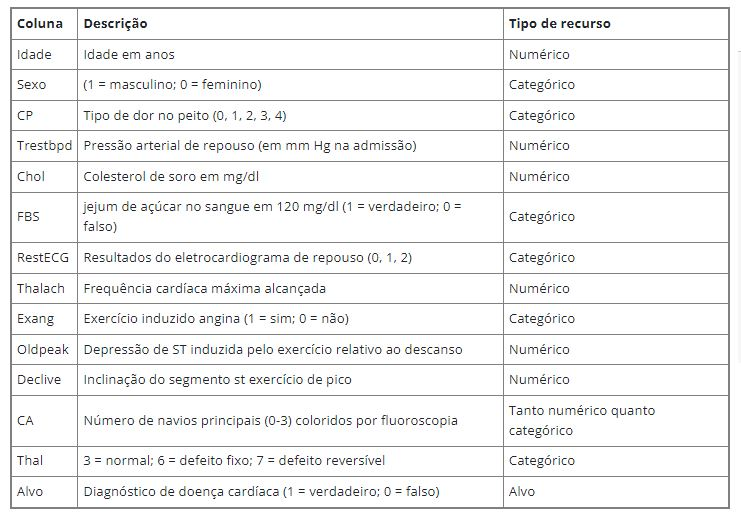


Fonte: Cleveland Clinic Foundation for Heart Disease (2020)

In [35]:
dataframe.shape

(303, 14)

**Mostrando algumas amostras**

In [4]:
dataframe.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


A última coluna, "alvo", indica se o paciente tem uma doença cardíaca (1) ou não (0).
Agora dividimos o conjunto de dados entre treinamento e validação:

In [36]:
val_dataframe = dataframe.sample(frac=0.2, random_state=1337)
train_dataframe = dataframe.drop(val_dataframe.index)

print(
    "Usar %d amostras para treinamento e %d para validação"
    % (len(train_dataframe), len(val_dataframe))
)

Usar 242 amostras para treinamento e 61 para validação


**Geramos o tf.data.Dataset para cada dataframe**

In [37]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("target")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

Cada um produz uma tupla onde há um dicionário de características e Dataset (input, target)

In [38]:
for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)

Input: {'age': <tf.Tensor: shape=(), dtype=int64, numpy=54>, 'sex': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'cp': <tf.Tensor: shape=(), dtype=int64, numpy=4>, 'trestbps': <tf.Tensor: shape=(), dtype=int64, numpy=110>, 'chol': <tf.Tensor: shape=(), dtype=int64, numpy=206>, 'fbs': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'restecg': <tf.Tensor: shape=(), dtype=int64, numpy=2>, 'thalach': <tf.Tensor: shape=(), dtype=int64, numpy=108>, 'exang': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'oldpeak': <tf.Tensor: shape=(), dtype=float64, numpy=0.0>, 'slope': <tf.Tensor: shape=(), dtype=int64, numpy=2>, 'ca': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'thal': <tf.Tensor: shape=(), dtype=string, numpy=b'normal'>}
Target: tf.Tensor(1, shape=(), dtype=int64)


**lotar o conjunto de dados**

In [39]:
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

**Pré-processamento de recursos com camadas keras**

**Características categóricas:** (one-hot encoding com categoryEncoding() e ou keras.layers.IntegerLookup() )

*   sex (sexo)
*   cp  (tipo de dor no peito)
*   fbs (jejum de açucar no sangue)
*   restecg  (resultado do eletrocardiograma em repouso)
*   exang    (exercício induzido angina)
*   ca       (resultado da fluoroscopia)

**Características numéricas contínuas**: (usaremos uma camada para garantir que a média de cada recurso seja 0 e seu desvio padrão seja 1.Normalization(). Uso de três funções para fazer as operações; encode_numerical_feature, encode_string_categorical_feature, encode_integer_categorical_feature)

*  age (idade)
*  trestbps (pressão arterial de repouso)
*  chol     (colesterol de soro em mg/dl)
*  thalach  (frequência cardíaca máxima alcançada)
*  oldpeak  (depressão de ST induzida pelo exercício relativo ao descanso)
*  slope   



In [40]:
def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = keras.layers.StringLookup if is_string else keras.layers.IntegerLookup
    # Criar uma camada de pesquisa que transformará strings em índices inteiros
    lookup = lookup_class(output_mode="binary")

    # Preparar um conjunto de dados que produza apenas nosso recurso
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Aprender o conjunto de valores de string possíveis e atribuir a eles um índice inteiro fixo
    lookup.adapt(feature_ds)

    # Transformar a entrada de string em índices inteiros
    encoded_feature = lookup(feature)
    return encoded_feature

In [41]:

def encode_numerical_feature(feature, name, dataset):
    # Criar uma camada de normalização para nosso recurso
    normalizer = keras.layers.Normalization()

    # Preparar um conjunto de dados que produza apenas nosso recurso
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Aprender as estatísticas dos dados
    normalizer.adapt(feature_ds)

    # Normalizar as entradas
    encoded_feature = normalizer(feature)
    return encoded_feature

In [42]:
# Recursos categóricos codificados como inteiros
sex = keras.Input(shape=(1,), name="sex", dtype="int64")
cp = keras.Input(shape=(1,), name="cp", dtype="int64")
fbs = keras.Input(shape=(1,), name="fbs", dtype="int64")
restecg = keras.Input(shape=(1,), name="restecg", dtype="int64")
exang = keras.Input(shape=(1,), name="exang", dtype="int64")
ca = keras.Input(shape=(1,), name="ca", dtype="int64")

In [43]:
# Recurso categórico codificado como string
thal = keras.Input(shape=(1,), name="thal", dtype="string")

In [44]:
# Recursos numéricos
age = keras.Input(shape=(1,), name="age")
trestbps = keras.Input(shape=(1,), name="trestbps")
chol = keras.Input(shape=(1,), name="chol")
thalach = keras.Input(shape=(1,), name="thalach")
oldpeak = keras.Input(shape=(1,), name="oldpeak")
slope = keras.Input(shape=(1,), name="slope")

In [45]:
all_inputs = [
    sex,
    cp,
    fbs,
    restecg,
    exang,
    ca,
    thal,
    age,
    trestbps,
    chol,
    thalach,
    oldpeak,
    slope,
]


In [46]:
# Recursos categóricos inteiros
sex_encoded = encode_categorical_feature(sex, "sex", train_ds, False)
cp_encoded = encode_categorical_feature(cp, "cp", train_ds, False)
fbs_encoded = encode_categorical_feature(fbs, "fbs", train_ds, False)
restecg_encoded = encode_categorical_feature(restecg, "restecg", train_ds, False)
exang_encoded = encode_categorical_feature(exang, "exang", train_ds, False)
ca_encoded = encode_categorical_feature(ca, "ca", train_ds, False)

In [47]:
# Características categóricas de string
thal_encoded = encode_categorical_feature(thal, "thal", train_ds, True)

In [48]:
# Recursos numéricos
age_encoded = encode_numerical_feature(age, "age", train_ds)
trestbps_encoded = encode_numerical_feature(trestbps, "trestbps", train_ds)
chol_encoded = encode_numerical_feature(chol, "chol", train_ds)
thalach_encoded = encode_numerical_feature(thalach, "thalach", train_ds)
oldpeak_encoded = encode_numerical_feature(oldpeak, "oldpeak", train_ds)
slope_encoded = encode_numerical_feature(slope, "slope", train_ds)

In [49]:
all_features = keras.layers.concatenate(
    [
        sex_encoded,
        cp_encoded,
        fbs_encoded,
        restecg_encoded,
        exang_encoded,
        slope_encoded,
        ca_encoded,
        thal_encoded,
        age_encoded,
        trestbps_encoded,
        chol_encoded,
        thalach_encoded,
        oldpeak_encoded,
    ]
)

**Construção do modelo**

In [50]:
x = keras.layers.Dense(32, activation="relu")(all_features)
x = keras.layers.Dropout(0.5)(x)
output = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(all_inputs, output)
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sex (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 cp (InputLayer)                [(None, 1)]          0           []                               
                                                                                                  
 fbs (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 restecg (InputLayer)           [(None, 1)]          0           []                               
                                                                                            

**Visualizar o gráfico de conectividade**

In [51]:
# `rankdir='LR'` gráfico horizontal
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


**Treinar o modelo**

In [ ]:
history = model.fit(train_ds, epochs=50, validation_data=val_ds)

**Plotar acurácia e o loss**

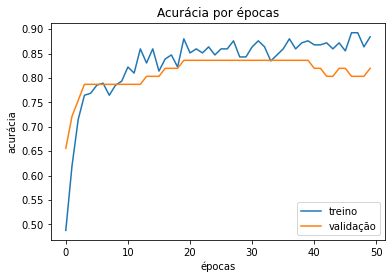

In [53]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Acurácia por épocas')
plt.xlabel('épocas')
plt.ylabel('acurácia')
plt.legend(['treino', 'validação'])


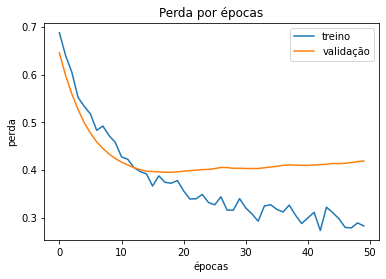

In [54]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perda por épocas')
plt.xlabel('épocas')
plt.ylabel('perda')
plt.legend(['treino', 'validação'])

Chegamos a uma precisão de **78%** de precisão de validação

**Inferência sobre novos dados**


In [55]:
sample = {
    "age": 20,
    "sex": 0,
    "cp": 4,
    "trestbps": 159,
    "chol": 280,
    "fbs": 1,
    "restecg": 2,
    "thalach": 170,
    "exang": 1,
    "oldpeak": 2.3,
    "slope": 3,
    "ca": 0,
    "thal": "fixed",
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = model.predict(input_dict)

print(
    "Este paciente em particular tem uma probabilidade de %.1f por cento "
    "de ter uma doença cardíaca, conforme avaliado pelo nosso modelo." % (100 * predictions[0][0],)
)

1/1 [==============================] - 1s 595ms/step
Este paciente em particular tem uma probabilidade de 75.0 por cento de ter uma doença cardíaca, conforme avaliado pelo nosso modelo.


In [65]:
db = os.getenv('DB')
#client = os.getenv('CLIENT_DEVELOP')
client = os.getenv('CLIENT_PRODUCT')
collection = os.getenv('COLLECTION')
model_name = os.getenv('MODEL_NAME')

In [59]:


def save_model_to_mongo(model, model_name, client, db, collection):

    myclient = pymongo.MongoClient(client)
    mydb = myclient[db]
    mycon = mydb[collection]

    pickle_model = pickle.dumps(model)

    result = mycon.insert_one({'model': pickle_model,'model_name':model_name, 'create_at':time.time()})
    print(result.inserted_id, "success")
    print(result)
    details = {
        'id': result.inserted_id,
        'model_name': model_name,
        'created_at': time.time()
    }

    return details


In [74]:
print(model_name)

heart


In [75]:
save_model_to_mongo(client=client,collection=collection,db=db,model=model,model_name=model_name)

INFO:tensorflow:Assets written to: ram://bd07dee1-bd54-4800-9ba9-c59a2451ac02/assets
62ae4854246731bd7023b16d success


{'id': ObjectId('62ae4854246731bd7023b16d'),
 'model_name': 'heart',
 'created_at': 1655588948.5455966}

In [76]:
def load_saved_model_from_mongo(model_name, client, db, collection):
    
    json_result= {}

    myclient = pymongo.MongoClient(client)
    mydb = myclient[db]
    mycon = mydb[collection]

    result = mycon.find({'model_name':model_name})
    for i in result:
        json_result = i

    pickled_model = json_result['model']

    return pickle.loads(pickled_model)

In [77]:


model_from_mongo = load_saved_model_from_mongo(model_name=model_name, client=client, db=db, collection=collection)

In [78]:
sample = {
    "age": 20,
    "sex": 0,
    "cp": 4,
    "trestbps": 159,
    "chol": 280,
    "fbs": 1,
    "restecg": 2,
    "thalach": 170,
    "exang": 1,
    "oldpeak": 2.3,
    "slope": 3,
    "ca": 0,
    "thal": "fixed",
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = model_from_mongo.predict(input_dict)

print(
    "Este paciente em particular tem uma probabilidade de %.1f por cento "
    "de ter uma doença cardíaca, conforme avaliado pelo nosso modelo." % (100 * predictions[0][0],)
)

1/1 [==============================] - 1s 509ms/step
Este paciente em particular tem uma probabilidade de 75.0 por cento de ter uma doença cardíaca, conforme avaliado pelo nosso modelo.
